# How to update graph state from nodes

### State
State in LangGraph can be a TypedDict, Pydantic model, or dataclass. Below we will use TypedDict. See this guide for detail on using Pydantic.

By default, graphs will have the same input and output schema, and the state determines that schema. See this guide for how to define distinct input and output schemas.

In [1]:
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict


class State(TypedDict):
    messages: list[AnyMessage]
    extra_field: int

In [2]:
from langchain_core.messages import AIMessage


def node(state: State):
    messages = state["messages"]
    new_message = AIMessage("Hello!")

    return {"messages": messages + [new_message], "extra_field": 10}

In [3]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(State)
graph_builder.add_node(node)
graph_builder.set_entry_point("node")
graph = graph_builder.compile()

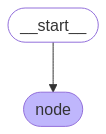

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
from langchain_core.messages import HumanMessage

result = graph.invoke({"messages": [HumanMessage("Hi")]})
result

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Hello!', additional_kwargs={}, response_metadata={})],
 'extra_field': 10}

In [6]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello!


In [9]:
from typing_extensions import Annotated

def add(left, right):
    """Can also import `add` from the `operator` built-in."""
    return left + right

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add]
    extra_field: int

In [10]:
def node(state: State):
    new_message = AIMessage("Hello!")
    return {"messages": [new_message], "extra_field": 10}

In [12]:
from langgraph.graph import START

graph = StateGraph(State).add_node(node).add_edge(START,"node").compile()

result = graph.invoke({"messages": [HumanMessage("Hi")]})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello!


In [13]:
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    extra_field: int

def node(state: State):
    new_message = AIMessage("Hello!")
    return {"messages": [new_message], "extra_field": 10}

graph = StateGraph(State).add_node(node).add_edge(START,"node").compile()

In [15]:
input_message = {"role": "user", "content": "Hii"}

result = graph.invoke({"messages": [input_message]})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hii
================================== Ai Message ==================================

Hello!


# How to create a sequence of steps

In [2]:
from typing_extensions import TypedDict


class State(TypedDict):
    value_1: str
    value_2: int

In [9]:
def step_1(state: State):
    return {"value_1": "a"}

def step_2(state: State):
    current_value_1 = state["value_1"]
    return {"value_1": f"{current_value_1} b"}

def step_3(state: State):
    return {"value_2": 10}

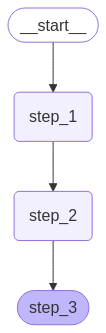

In [10]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State)

## Add nodes
graph_builder.add_node(step_1)
graph_builder.add_node(step_2)
graph_builder.add_node(step_3)

## Add edges
graph_builder.add_edge(START,"step_1")
graph_builder.add_edge("step_1","step_2")
graph_builder.add_edge("step_2","step_3")

## Compile
graph = graph_builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
graph.invoke({"value_1": "c"})

{'value_1': 'a b', 'value_2': 10}

### Built-in shorthand

In [12]:
graph_builder = StateGraph(State).add_sequence([step_1, step_2, step_3])
graph_builder.add_edge(START,"step_1")

graph = graph_builder.compile()

graph.invoke({"value_1": "c"})

{'value_1': 'a b', 'value_2': 10}